In [ ]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import math

In [ ]:
pd.set_option('display.max_columns', 184)
pd.set_option('display.max_rows', 184)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_seq_items', 184)
pd.set_option('display.width', 100)

## Fonctions

In [ ]:
def listMainCat(serie, seuil=10, en='', clean=True):
    '''
    liste dans la série toutes les valeurs existantes et trie du plus au moins frequent (ne considère pas ceux en dessous du seuil)
    seuil peut être un entier et du coup il ejecte ceux qui sont d'une valeur inférieur à ce nombre
    ou il peut être une fraction qui sera le pourcentage en desous duquel il ejecte
    clean permet de retirer les espaces qui sont au début ou à la fin des chaines de caractères
    '''
    serie_temp = pd.Series()
    serie_values = serie.value_counts()
    for i in range(serie_values.shape[0]):
        val = serie_values.index[i]
        for r in range(val.count(',')+1):
            if clean:
                val = val.strip()
            virgule = val.find(',')
            if virgule == -1:
                if val[len(en):] in serie_temp:
                    serie_temp[val[len(en):]] += serie_values[i]
                else:
                    serie_temp[val[len(en):]] = serie_values[i]
            else:
                if val[len(en):virgule] in serie_temp:
                    serie_temp[val[len(en):virgule]] += serie_values[i]
                else:
                    serie_temp[val[len(en):virgule]] = serie_values[i]
                val = val[virgule+1:]
    serie_temp.sort_values(ascending=False, inplace=True)
    if isinstance(seuil, int):
        for i in range(serie_temp.shape[0]):
            if serie_temp.iloc[i] < seuil:
                serie_temp = serie_temp.iloc[0:i]
                break
    elif isinstance(seuil, float):
        for i in range(serie_temp.shape[0]):
            if serie_temp.iloc[i]/serie.shape[0] < seuil:
                serie_temp = serie_temp.iloc[0:i]
                break
    return serie_temp

In [ ]:
def multiOnehotTags(serie, seuil=10, en='', clean=True):
    '''
    onehot pour une variable qui à plusieurs valeurs dans une celule
    '''
    liste = listMainCat(serie=serie, seuil=seuil, en=en, clean=clean)
    df_temp = pd.DataFrame(columns=liste.keys())
    for i in serie.index:
        val = serie.loc[i]
        df_temp.loc[i] = 0
        if type(val) == str:
            for r in range(val.count(','+ en)+1):
                if clean:
                    val = val.strip()
                virgule = val.find(',' + en)
                if virgule == -1:
                    if val[len(en):] in liste:
                        df_temp.loc[i,val[len(en):]] = 1
                else:
                    if val[len(en):virgule] in liste:
                        df_temp.loc[i,val[len(en):virgule]] = 1
                val = val[virgule + 1:]
        else:
            df_temp.loc[i] = 0
    return df_temp.fillna(0)

In [ ]:
def locSplit(loc):
    '''
    récupère les informations de localisation
    '''
    loc1 = re.sub('"','\\"', loc)
    loc2 = re.sub('\'','"', loc1)
    loc3 = json.loads(loc2)
    loc4 = json.loads(loc3['human_address'])
    return pd.Series((loc3['latitude'], loc3['longitude'], loc4['address'], loc4['zip']), index=['Latitude', 'Longitude', 'Address', 'ZipCode'])

In [ ]:
def topCorrel(df, seuil):
    '''
    liste du plus au moins correlé les variables
    '''
    liste_top = pd.Series()
    correl = df.corr()
    for iind, i in enumerate(correl.columns):
        for rind, r in enumerate(correl.index):
            if iind < rind:
                if abs(correl.loc[i,r]) >= seuil:
                    liste_top[i+ ' - '+r] = correl.loc[i,r]
            else:
                pass
    return liste_top.sort_values(ascending=False)

## Nettoyage

### chargement des bases de données

In [ ]:
df_2015 = pd.read_csv('Data/2015-building-energy-benchmarking.csv')
df_2016 = pd.read_csv('Data/2016-building-energy-benchmarking.csv')

### traitement des deux dataset séparément

#### Sur 2016

In [ ]:
# "Comments" est vide
df_2016.drop(['Comments'], axis=1, inplace=True)
# "City" et "State" n'ont qu'une valeur unique
df_2016.drop(['State'], axis=1, inplace=True)
df_2016.drop(['City'], axis=1, inplace=True)

#### Sur 2015

In [ ]:
# "Comment" est presque vide, donc elle n'est pas exploitable
df_2015.drop(['Comment'], axis=1, inplace=True)
# cette variable n'est que pour 2015 et elle n'est pas bien expliquée, et la distribution n'est pas centrée (donc pas remplaçable par la moyenne)
df_2015.drop(['Seattle Police Department Micro Community Policing Plan Areas'], axis=1, inplace=True)
# c'est le district du conseil municipal, il y a que deux valeurs 1 et 2, et il n'est présent que sur 2015, il très peu renseigné
df_2015.drop(['City Council Districts'], axis=1, inplace=True)
# "SPD Beats" sont les Battements du département de police de Seattle présents que sur 2015
df_2015.drop(['SPD Beats'], axis=1, inplace=True)
# "Zip Codes" est le code postal, mais on l'a deja avec la localisation
df_2015.drop(['Zip Codes'], axis=1, inplace=True)
# à par 17 valeurs le reste c'est zero donc pas exploitable, en plus c'est que sur 2015
df_2015.drop(['OtherFuelUse(kBtu)'], axis=1, inplace=True)

##### création des variables de localisation à partir de la variable "location"

In [ ]:
df_2015 = df_2015.join(df_2015['Location'].apply(lambda loc: locSplit(loc)))
df_2015.drop('Location', axis=1, inplace=True)

### Fusion des datasets

In [ ]:
df_total = pd.concat([df_2015,df_2016], ignore_index=True)

### Traitement sur dataset unifié

##### Correction des variables présentes

Suppression des variables inutiles

In [ ]:
# "YearsENERGYSTARCertified" est presque vide, et mal renseignée
df_total.drop(['YearsENERGYSTARCertified'], axis=1, inplace=True)
# "Outlier" est presque vide
df_total.drop(['Outlier'], axis=1, inplace=True)
# "2010 Census Tracts" est presque vide
df_total.drop(['2010 Census Tracts'], axis=1, inplace=True)
# inutile de connaitre le nom de la propriété
df_total.drop(['PropertyName'], axis=1, inplace=True)
# inutile de connaitre l'identifiant
df_total.drop(['OSEBuildingID'], axis=1, inplace=True)
# d'autres variables expliquent une information similaire "LargestPropertyUseType"
df_total.drop(['PrimaryPropertyType'], axis=1, inplace=True)
# cette variable n'est pas pertinante dans la prédiction du model
df_total.drop(['DefaultData'], axis=1, inplace=True)
# cette variable n'est pas pertinante dans la prédiction du model
df_total.drop(['ComplianceStatus'], axis=1, inplace=True)
# cette variable n'est que la somme de deux autres (PropertyGFABuilding(s) et PropertyGFAParking)
df_total.drop(['PropertyGFATotal'], axis=1, inplace=True)

On évite la fuite de données en retirant les variables qui ont un lien direct avec la target

In [ ]:
df_total.drop(['NaturalGas(kBtu)', 'Electricity(kBtu)', 'SourceEUIWN(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)'], axis=1, inplace = True)
df_total.drop(['SteamUse(kBtu)', 'Electricity(kWh)', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'NaturalGas(therms)'], axis=1, inplace=True)

on réassemble les variables qui n'ont pas le même nom sur les deux dataset, et qui pourtant sont pareilles

In [ ]:
df_total['TotalGHGEmissions(MetricTonsCO2e)'] = df_total['TotalGHGEmissions'].fillna(0) + df_total['GHGEmissions(MetricTonsCO2e)'].fillna(0)
df_total['TotalGHGEmissionsIntensity(kgCO2e/ft2)'] = df_total['GHGEmissionsIntensity'].fillna(0) + df_total['GHGEmissionsIntensity(kgCO2e/ft2)'].fillna(0)
df_total.drop(['TotalGHGEmissions', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'TotalGHGEmissionsIntensity(kgCO2e/ft2)'], axis=1, inplace=True)

##### suppression des individus

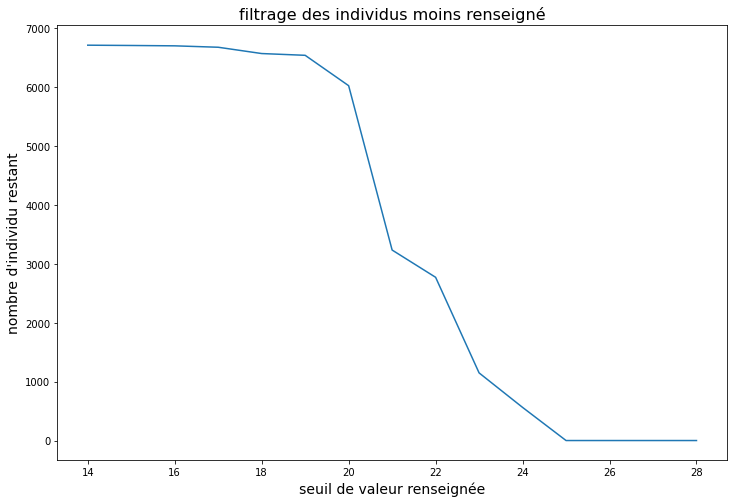

le 19 est retenu


In [ ]:
miss_value = []
for i in range(14, 29):
    miss_value.append(df_total.dropna(thresh=i).shape[0])
plt.figure(figsize=(12,8))
plt.plot(range(14, 29), miss_value)
plt.title('filtrage des individus moins renseigné', fontsize=16)
plt.xlabel("seuil de valeur renseignée", fontsize=14)
plt.ylabel("nombre d'individu restant", fontsize=14)
plt.show()
print('le 19 est retenu')

In [ ]:
# retire les lignes les moins renseignées, retire 172 individus
df_total.dropna(thresh=19, inplace=True)

In [ ]:
# supprime les doublons, retire 127 individus
df_total.drop_duplicates(subset=['Latitude', 'Longitude', 'TaxParcelIdentificationNumber', 'DataYear'], inplace=True, ignore_index=True)
# il ne sert plus à rien maintenant qu'on a retiré les doublons
df_total.drop(['TaxParcelIdentificationNumber'], axis=1, inplace=True)

##### variable de localisation

In [ ]:
# les définir comme flottantes
df_total['Longitude'] = df_total['Longitude'].astype(float)
df_total['Latitude'] = df_total['Latitude'].astype(float)

Text(0.5, 1.0, 'Carte quartier et district de Seattle')

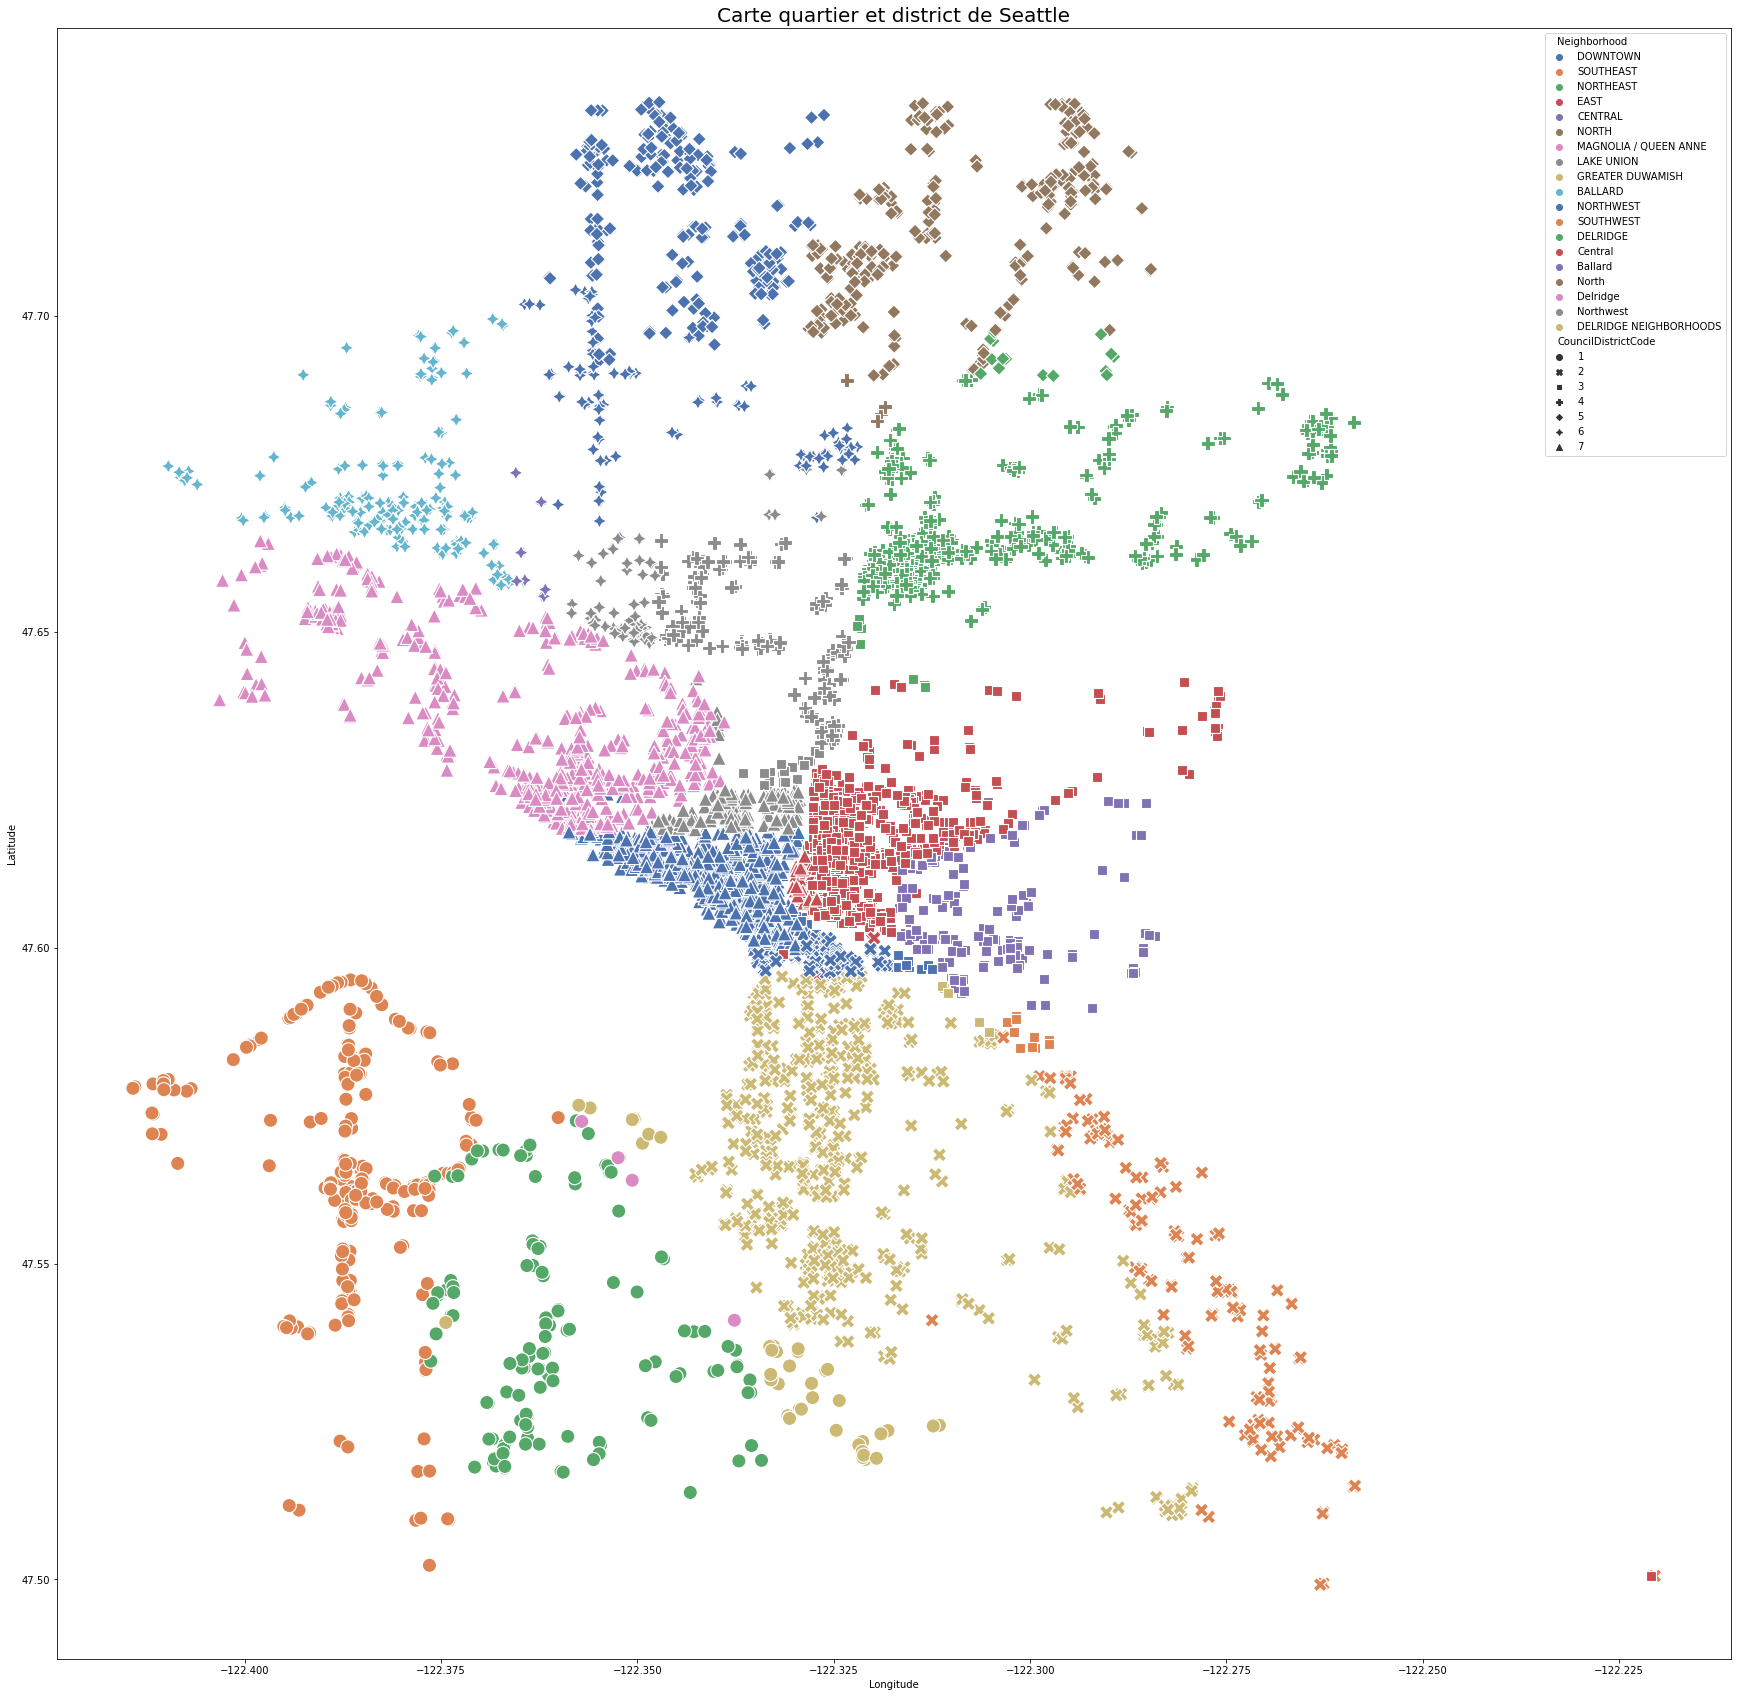

In [ ]:
plt.figure(figsize=(30,30))
sns.scatterplot(data=df_total, x='Longitude', y='Latitude', style='CouncilDistrictCode', palette="deep", hue='Neighborhood', s=200)
plt.title('Carte quartier et district de Seattle', fontsize=20)

In [ ]:
# l'adresse est compliquée à analyser, et le ZipCode est déjà presque équivalent au quartier 'Neighborhood', il a en plus 83 valeurs différentes
df_total.drop(['Address'], axis=1, inplace=True)
df_total.drop(['ZipCode'], axis=1, inplace=True)

##### gestion des outliers

In [ ]:
# la suppression des outliers a retiré 1 individu
df_total = df_total[(df_total['NumberofBuildings'] <= 50.0) | (df_total['NumberofBuildings'].isna())]

##### controle des correlations

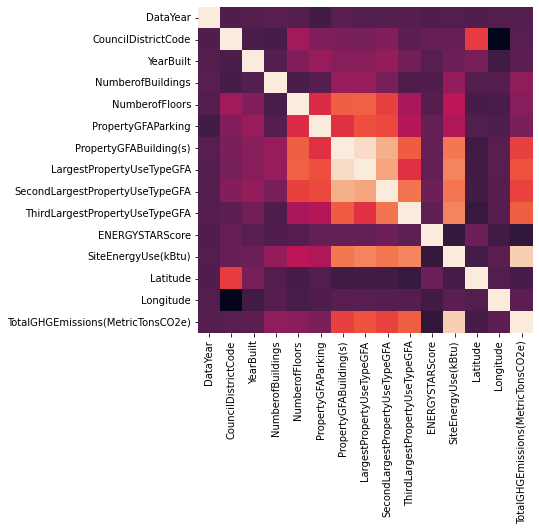

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(df_total.corr(), cbar=False)

Il y a des variables très corrélées, mais on les garde, car elles ne communiquent pas de la même information.

In [ ]:
topCorrel(df_total, 0.4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


PropertyGFABuilding(s) - LargestPropertyUseTypeGFA                     0.949314
SiteEnergyUse(kBtu) - TotalGHGEmissions(MetricTonsCO2e)                0.905692
PropertyGFABuilding(s) - SecondLargestPropertyUseTypeGFA               0.802313
LargestPropertyUseTypeGFA - SecondLargestPropertyUseTypeGFA            0.774636
LargestPropertyUseTypeGFA - SiteEnergyUse(kBtu)                        0.674524
ThirdLargestPropertyUseTypeGFA - SiteEnergyUse(kBtu)                   0.674394
PropertyGFABuilding(s) - SiteEnergyUse(kBtu)                           0.642917
SecondLargestPropertyUseTypeGFA - SiteEnergyUse(kBtu)                  0.635152
SecondLargestPropertyUseTypeGFA - ThirdLargestPropertyUseTypeGFA       0.628675
NumberofFloors - LargestPropertyUseTypeGFA                             0.578445
NumberofFloors - PropertyGFABuilding(s)                                0.571431
ThirdLargestPropertyUseTypeGFA - TotalGHGEmissions(MetricTonsCO2e)     0.569471
PropertyGFABuilding(s) - ThirdLargestPro

##### remplissage des valeurs manquantes

In [ ]:
# la distribution est centrée, on peut utiliser la médiane, car il y a des valeurs extrêmes
df_total['NumberofFloors'].fillna(df_total['NumberofFloors'].median(), inplace=True)

In [ ]:
# la distribution est centrée, on peut utiliser la médiane, car il y a des valeurs extrêmes
df_total['SiteEnergyUse(kBtu)'].fillna(df_total['SiteEnergyUse(kBtu)'].median(), inplace=True)

##### Création de nouvelles variables

In [ ]:
# on fait une colonne par type d'usage, ou l'on renseigne la surface allouée comme valeur
df_PropertyUse = pd.DataFrame()
df_total[['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']] = df_total[['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']].fillna(0)
df_total[['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']] = df_total[['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']].fillna('null')
for i in df_total.index:
    df_PropertyUse.loc[i,df_total.loc[i,'LargestPropertyUseType'] + ' GFA'] = df_total.loc[i,'LargestPropertyUseTypeGFA']
    df_PropertyUse.loc[i,df_total.loc[i,'SecondLargestPropertyUseType'] + ' GFA'] = df_total.loc[i,'SecondLargestPropertyUseTypeGFA']
    df_PropertyUse.loc[i,df_total.loc[i,'ThirdLargestPropertyUseType'] + ' GFA'] = df_total.loc[i,'ThirdLargestPropertyUseTypeGFA']
df_PropertyUse.fillna(0, inplace=True)
df_total = df_total.join([df_PropertyUse['Hotel GFA'], df_PropertyUse.iloc[:,2:]])
# on retire les colonnes qui ne servent plus à rien
df_total.drop(['LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'], axis=1, inplace=True)

In [ ]:
# fait le multi OneHot de ListOfAllPropertyUseTypes
df_total = df_total.join(multiOnehotTags(df_total['ListOfAllPropertyUseTypes'], seuil=0.01, clean=True))
df_total.drop(['ListOfAllPropertyUseTypes'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
# oneHot classique de BuildingType, Neighborhood et CouncilDistrictCode
df_total = df_total.join(pd.get_dummies(df_total['BuildingType']))
df_total = df_total.join(pd.get_dummies(df_total['Neighborhood']))
df_total = df_total.join(pd.get_dummies(df_total['CouncilDistrictCode'], prefix='District '))
df_total.drop(['BuildingType', 'Neighborhood', 'Delridge', 'Ballard', 'CouncilDistrictCode'], axis=1, inplace=True)

In [ ]:
# on met au logarithme les variables target car elles ont une distribution qui s'y prête
df_total[['SiteEnergyUse(kBtu)Log', 'TotalGHGEmissions(MetricTonsCO2e)Log']] = np.log(df_total[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions(MetricTonsCO2e)']] + 1)

###### la proportion de consommation énergétique et d'émission de co2 moyenne par type d'usage

In [ ]:
rez_co2 = pd.DataFrame(df_total.iloc[:,78:98])
for col in df_total.iloc[:,78:98]:
    rez_co2[col][df_total[col] == 1] = df_total['TotalGHGEmissions(MetricTonsCO2e)']
render_co2 = rez_co2[rez_co2 != 0].mean()
render_co2_std = render_co2/render_co2.std()

In [ ]:
rez_engy = pd.DataFrame(df_total.iloc[:,78:98])
for col in df_total.iloc[:,78:98]:
    rez_engy[col][df_total[col] == 1] = df_total['SiteEnergyUse(kBtu)']
render_engy = rez_engy[rez_engy != 0].mean()
render_engy_std = render_engy/render_engy.std()

AttributeError: ignored

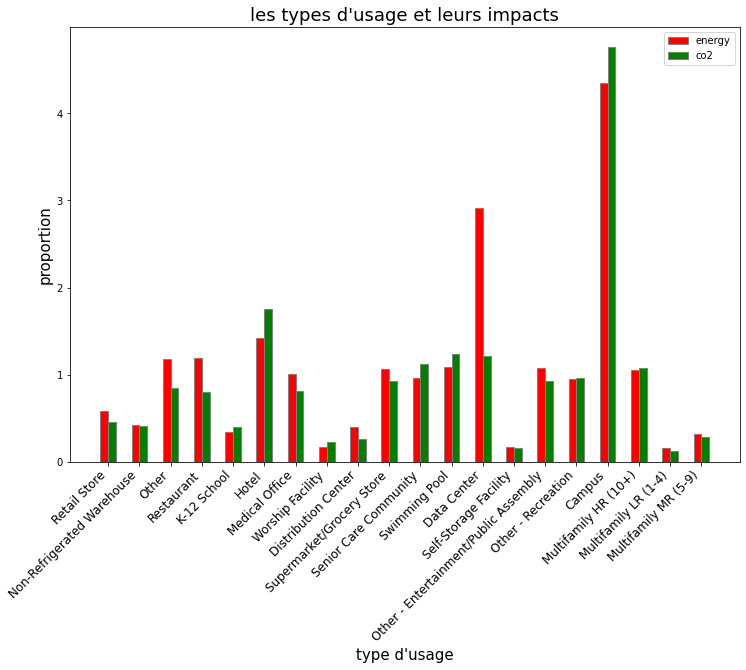

In [ ]:
# set width of bar
barWidth = 0.25
fig, ax = plt.subplots(figsize =(12, 8))
 
# set height of bar
energy = render_engy_std.values
co2 = render_co2_std.values
 
# Set position of bar on X axis
br1 = np.arange(len(energy))
br2 = [x + barWidth for x in br1]
 
# Make the plot
ax.bar(br1, energy, color ='r', width = barWidth,
        edgecolor ='grey', label ='energy')
ax.bar(br2, co2, color ='g', width = barWidth,
        edgecolor ='grey', label ='co2')
 
# Adding Xticks
plt.title('les types d\'usage et leurs impacts', fontsize=18)
plt.xlabel('type d\'usage', fontsize = 15)
plt.ylabel('proportion', fontsize = 15)
ax.legend()
plt.xticks([r + (barWidth/2) for r in range(len(energy))],
        render_co2.index, fontsize=12, Rotation=45, fontdict={'horizontalalignment': 'right'})

plt.show()

## Export

In [ ]:
df_total.to_csv('/content/drive/MyDrive/Data Science/Data base/building-energy-benchmarking.csv')